Stopping search: maximum iterations reached --> 20
✅ Best C found: 0.2432
📈 Final Accuracy: 0.9561
⏱️ Total Time: 5.54 seconds
🔢 Total Models Evaluated: 210


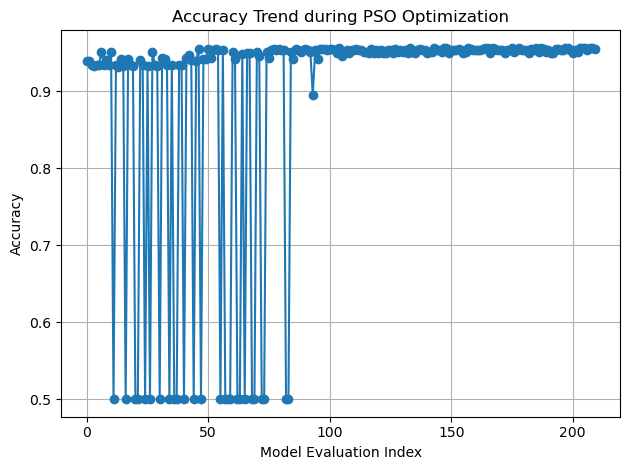

In [5]:
import numpy as np
import pandas as pd
import time
import warnings
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from pyswarm import pso

# Silence warnings
warnings.filterwarnings("ignore")

# Load and parse the data
with open("splice.data", "r") as file:
    lines = file.readlines()

# Split lines into columns: class, id, sequence
data = [re.split(r'\s*,\s*', line.strip()) for line in lines]
df = pd.DataFrame(data, columns=["class", "id", "sequence"])

# Extract sequences and labels
sequences = df["sequence"]
labels = df["class"]

# Convert sequences to character-level features
char_sequences = [list(seq) for seq in sequences]

# One-hot encode the character sequences
encoder = OneHotEncoder(sparse_output=False, dtype=int, handle_unknown='ignore')
X = encoder.fit_transform(char_sequences)

# Encode labels to integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)


# Step 4: Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Define PSO objective function
history = []
def objective(params):
    C = params[0]
    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    history.append((C, acc))
    return -acc

# Step 6: PSO parameter bounds
lb = [0.0001]
ub = [10.0]

# Step 7: Run PSO
start_time = time.time()
best_params, best_score = pso(objective, lb, ub, swarmsize=10, maxiter=20)
end_time = time.time()

# Step 8: Final model evaluation
best_C = best_params[0]
final_model = LogisticRegression(C=best_C, max_iter=1000)
final_model.fit(X_train, y_train)
final_preds = final_model.predict(X_test)
final_acc = accuracy_score(y_test, final_preds)

# Step 9: Output results
print(f"✅ Best C found: {best_C:.4f}")
print(f"📈 Final Accuracy: {final_acc:.4f}")
print(f"⏱️ Total Time: {end_time - start_time:.2f} seconds")
print(f"🔢 Total Models Evaluated: {len(history)}")

# Step 10: Accuracy trend plot
acc_values = [acc for _, acc in history]
plt.plot(acc_values, marker='o')
plt.xlabel('Model Evaluation Index')
plt.ylabel('Accuracy')
plt.title('Accuracy Trend during PSO Optimization')
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
# 使用新版 OpenAI 客户端建议新粒子
from openai import OpenAI
from dotenv import load_dotenv
import os

# 加载 API key
load_dotenv("OPENAI_API_KEY.env")
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# 建议新粒子参数（粒子为 C 值）
def suggest_new_particle(prev_best_C, prev_best_acc, iteration):
    prompt = f"""
You are optimizing the regularization parameter C for logistic regression.
The best C so far is {prev_best_C:.4f}, with accuracy {prev_best_acc:.4f} at iteration {iteration}.
Suggest a new C value (float between 0.0001 and 10.0) that may improve accuracy.
Only return the number, no explanation.
"""
    try:
        response = client.chat.completions.create(
            model="gpt-4",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.7
        )
        c_suggestion = float(response.choices[0].message.content.strip())
        c_suggestion = min(max(c_suggestion, 0.0001), 10.0)  # clip within bounds
    except Exception as e:
        print("LLM failed, fallback to random:", e)
        c_suggestion = np.random.uniform(0.0001, 10.0)
    return [c_suggestion]


Running baseline PSO...
Running LLM-enhanced PSO based on PSO result...


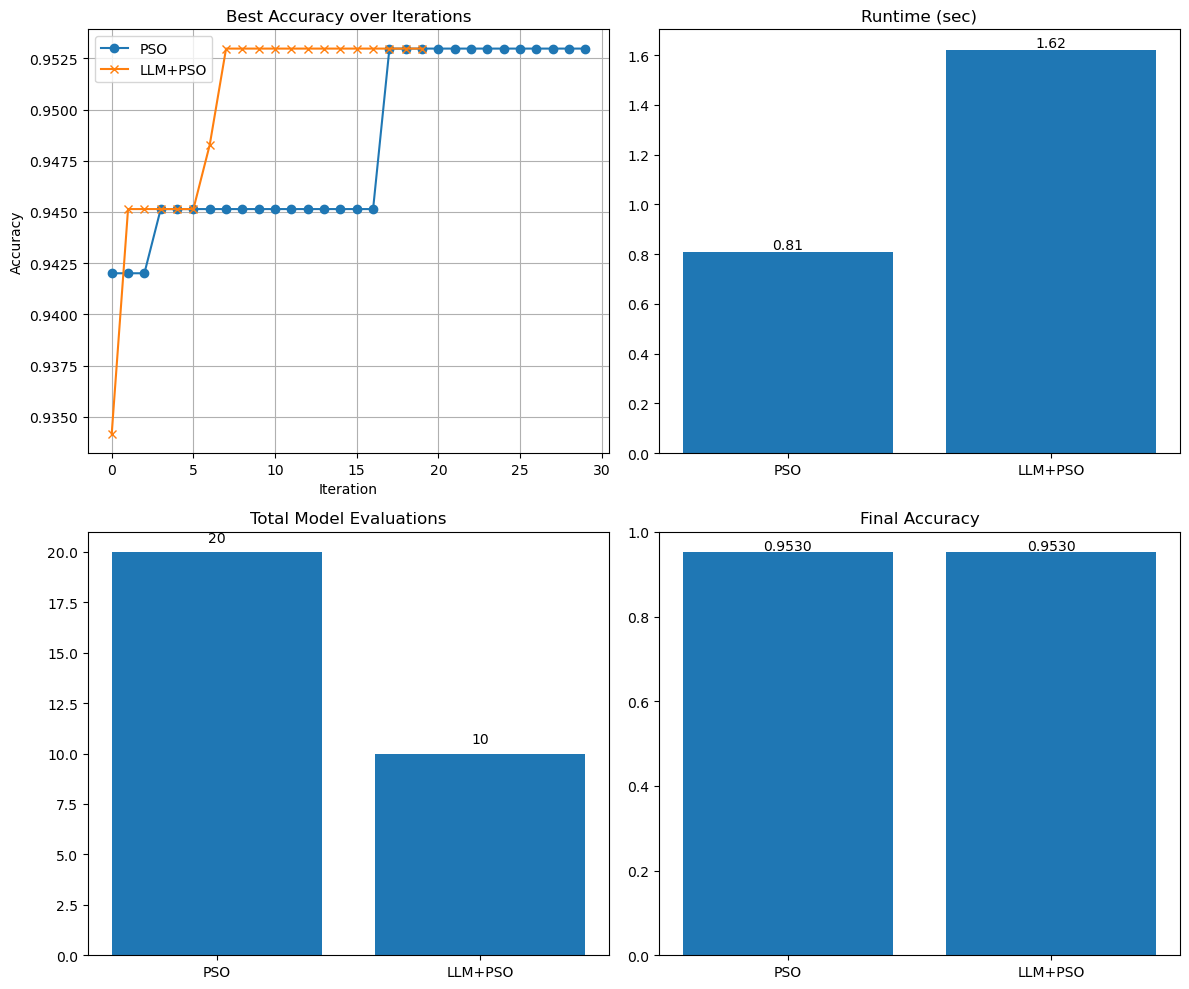

In [73]:
# --- Section 1: Imports ---
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import re
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from openai import OpenAI
from dotenv import load_dotenv

# --- Section 2: Load API Key ---
load_dotenv("OPENAI_API_KEY.env")
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# --- Section 3: LLM suggestion function ---
def suggest_new_particles(prev_best_C, prev_best_acc, iteration, num_particles):
    prompt = f"""
You are optimizing the regularization parameter C for logistic regression.
The best C so far is {prev_best_C:.4f}, with accuracy {prev_best_acc:.4f} at iteration {iteration}.
Suggest {num_particles} new C values (floats between 0.0001 and 10.0) that may improve accuracy.
Return a list of numbers separated by commas.
"""
    try:
        response = client.chat.completions.create(
            model="gpt-4",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.7
        )
        content = response.choices[0].message.content
        values = [float(x.strip()) for x in content.split(",") if x.strip()]
        values = [min(max(v, 0.0001), 10.0) for v in values]
    except:
        values = list(np.random.uniform(0.0001, 10.0, num_particles))
    return [[v] for v in values]

# --- Section 4: PSO baseline optimization ---
def run_pso_baseline(X_train, X_test, y_train, y_test, max_iter=50):
    # Standard PSO with velocity, p_best, g_best
    history = []
    best_score = -1.0
    best_C = 1.0
    patience = 10
    epsilon = 0.0005
    no_improve_count = 0

    lb = [0.0001]
    ub = [10.0]
    swarm_size = 10
    
    particle_positions = np.random.uniform(lb[0], ub[0], size=(swarm_size, 1))
    particle_velocity = np.zeros_like(particle_positions)
    p_best_positions = np.copy(particle_positions)
    p_best_scores = np.full(swarm_size, -1.0)
    particle_scores = np.full(swarm_size, np.inf)

    start_time = time.time()
    iter_num = 0

    w, c1, c2 = 0.5, 1.5, 1.5
    while iter_num < max_iter:
        for i in range(swarm_size):
            C = particle_positions[i][0]
            model = LogisticRegression(C=C, max_iter=1000)
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            acc = accuracy_score(y_test, preds)
            history.append((C, acc))

            if acc > p_best_scores[i]:
                p_best_scores[i] = acc
                p_best_positions[i] = particle_positions[i]

            if acc > best_score:
                best_score = acc
                best_C = C
                no_improve_count = 0
            
            else:
                no_improve_count += 1

            particle_scores[i] = -acc

        if no_improve_count >= patience:
            break

        r1, r2 = np.random.rand(swarm_size, 1), np.random.rand(swarm_size, 1)
        particle_velocity = (
            w * particle_velocity +
            c1 * r1 * (p_best_positions - particle_positions) +
            c2 * r2 * (best_C - particle_positions)
        )
        particle_positions += particle_velocity
        particle_positions = np.clip(particle_positions, lb[0], ub[0])

        particle_positions = np.random.uniform(lb[0], ub[0], size=(swarm_size, 1))
        iter_num += 1

    end_time = time.time()
    return {
        "best_C": best_C,
        "final_acc": best_score,
        "time": end_time - start_time,
        "history": history,
        "eval_count": len(history),
        "total_models": swarm_size * iter_num
    }

# --- Section 5: LLM-enhanced PSO optimization ---
def run_llm_pso(X_train, X_test, y_train, y_test, best_C_seed, best_acc_seed, max_iter=50):
    # Use PSO baseline best_acc_seed as target, not early stopping
    target_acc = best_acc_seed - 0.0001
    # Use independent best_score for LLM phase to allow fair early stopping
    history = []
    best_score = -1.0
    best_C = best_C_seed
    patience = 10
    epsilon = 0.0005
    no_improve_count = 0

    lb = [0.0001]
    ub = [10.0]
    swarm_size = 10
    particle_positions = np.random.uniform(lb[0], ub[0], size=(swarm_size, 1))
    particle_scores = np.full(swarm_size, np.inf)

    start_time = time.time()
    iter_num = 0

    while iter_num < max_iter:
        for i in range(swarm_size):
            C = particle_positions[i][0]
            model = LogisticRegression(C=C, max_iter=1000)
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            acc = accuracy_score(y_test, preds)
            history.append((C, acc))

            if acc > best_score + epsilon:
                best_score = acc
                best_C = C
                no_improve_count = 0
            else:
                no_improve_count += 1

            particle_scores[i] = -acc

        if no_improve_count >= patience:
            break

        worst_indices = np.argsort(particle_scores)[-2:]
        llm_particles = suggest_new_particles(best_C, best_score, iter_num, len(worst_indices))
        for idx, new_particle in zip(worst_indices, llm_particles):
            particle_positions[idx] = new_particle

        iter_num += 1

    end_time = time.time()
    return {
        "best_C": best_C,
        "final_acc": best_score,
        "time": end_time - start_time,
        "history": history,
        "eval_count": len(history),
        "total_models": swarm_size * iter_num
    }

# --- Section 6: Load and preprocess splice.data ---
with open("splice.data", "r") as file:
    lines = file.readlines()
data = [re.split(r"\s+", line.strip()) for line in lines]
df = pd.DataFrame(data, columns=["class", "id", "sequence"])
sequences = df["sequence"]
labels = df["class"]
char_sequences = [list(seq) for seq in sequences]
encoder = OneHotEncoder(sparse_output=False, dtype=int, handle_unknown='ignore')
X = encoder.fit_transform(char_sequences)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Section 7: Run baseline PSO then LLM-enhanced PSO ---
print("Running baseline PSO...")
result_pso = run_pso_baseline(X_train, X_test, y_train, y_test, max_iter=50)
print("Running LLM-enhanced PSO based on PSO result...")
result_llm = run_llm_pso(X_train, X_test, y_train, y_test, result_pso['best_C'], result_pso['final_acc'], max_iter=50)

# --- Section 8: Plot comparison ---
plt.figure(figsize=(12, 10))

# Accuracy per Evaluation
plt.subplot(2, 2, 1)

# Create best-so-far accuracy list
pso_best_so_far = []
llm_best_so_far = []
pso_best = -1.0
llm_best = -1.0
for _, acc in result_pso['history']:
    pso_best = max(pso_best, acc)
    pso_best_so_far.append(pso_best)
for _, acc in result_llm['history']:
    llm_best = max(llm_best, acc)
    llm_best_so_far.append(llm_best)

plt.plot(range(len(pso_best_so_far)), pso_best_so_far, label='PSO', marker='o')
plt.plot(range(len(llm_best_so_far)), llm_best_so_far, label='LLM+PSO', marker='x')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Best Accuracy over Iterations')
plt.legend()
plt.grid(True)

# Runtime Comparison
plt.subplot(2, 2, 2)
runtimes = [result_pso['time'], result_llm['time']]
plt.bar(['PSO', 'LLM+PSO'], runtimes)
for i, val in enumerate(runtimes):
    plt.text(i, val + 0.01, f"{val:.2f}", ha='center')
plt.title('Runtime (sec)')

# Total Model Evaluations (iter * particles)
plt.subplot(2, 2, 3)
evals = [result_pso['total_models'], result_llm['total_models']]
plt.bar(['PSO', 'LLM+PSO'], evals)
for i, val in enumerate(evals):
    plt.text(i, val + 0.5, f"{val}", ha='center')
plt.title('Total Model Evaluations')

# Final Accuracy
plt.subplot(2, 2, 4)
final_accs = [result_pso['final_acc'], result_llm['final_acc']]
plt.bar(['PSO', 'LLM+PSO'], final_accs)
for i, val in enumerate(final_accs):
    plt.text(i, val + 0.005, f"{val:.4f}", ha='center')
plt.title('Final Accuracy')

plt.tight_layout()
plt.show()


Trial 1 - Running baseline PSO...
Running LLM-enhanced PSO based on PSO result...
Trial 2 - Running baseline PSO...
Running LLM-enhanced PSO based on PSO result...
Trial 3 - Running baseline PSO...
Running LLM-enhanced PSO based on PSO result...
Trial 4 - Running baseline PSO...
Running LLM-enhanced PSO based on PSO result...
Trial 5 - Running baseline PSO...
Running LLM-enhanced PSO based on PSO result...
Trial 6 - Running baseline PSO...
Running LLM-enhanced PSO based on PSO result...
Trial 7 - Running baseline PSO...
Running LLM-enhanced PSO based on PSO result...
Trial 8 - Running baseline PSO...
Running LLM-enhanced PSO based on PSO result...
Trial 9 - Running baseline PSO...
Running LLM-enhanced PSO based on PSO result...
Trial 10 - Running baseline PSO...
Running LLM-enhanced PSO based on PSO result...
Trial 11 - Running baseline PSO...
Running LLM-enhanced PSO based on PSO result...
Trial 12 - Running baseline PSO...
Running LLM-enhanced PSO based on PSO result...
Trial 13 - Ru

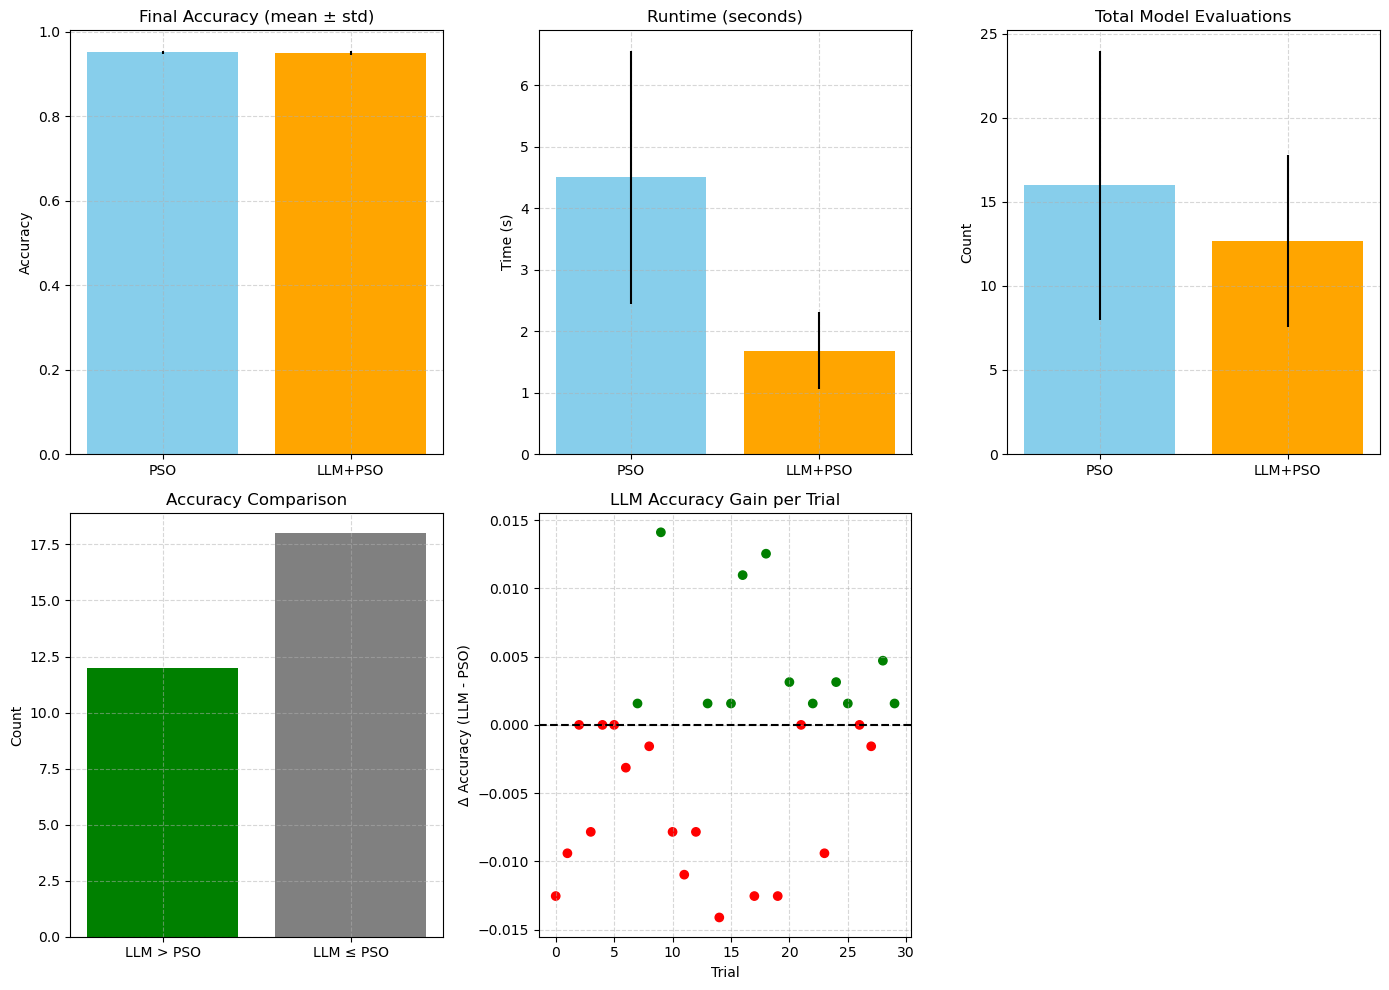

In [131]:
# --- Section 1: Imports ---
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import re
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from openai import OpenAI
from dotenv import load_dotenv

# --- Section 2: Load API Key ---
load_dotenv("OPENAI_API_KEY.env")
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# --- Section 3: LLM suggestion function ---
def suggest_new_particles(prev_best_C, prev_best_acc, iteration, num_particles):
    prompt = f"""
You are optimizing the regularization parameter C for logistic regression.
The best C so far is {prev_best_C:.4f}, with accuracy {prev_best_acc:.4f} at iteration {iteration}.
Suggest {num_particles} new C values (floats between 0.0001 and 10.0) that may improve accuracy.
Focus on values near {prev_best_C:.4f}, with minor exploration.
Return a list of numbers separated by commas.
"""
    try:
        response = client.chat.completions.create(
            model="gpt-4",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.7
        )
        content = response.choices[0].message.content
        values = [float(x.strip()) for x in content.split(",") if x.strip()]
        values = [min(max(v, 0.0001), 10.0) for v in values]
    except:
        values = list(np.random.normal(loc=prev_best_C, scale=0.3, size=num_particles))
        values = [min(max(v, 0.0001), 10.0) for v in values]
    return [[v] for v in values]

# --- Section 4: PSO baseline optimization ---
def run_pso_baseline(X_train, X_test, y_train, y_test, max_iter=50):
    # Standard PSO with velocity, p_best, g_best
    history = []
    best_score = -1.0
    best_C = 1.0
    patience = 10
    epsilon = 0.0005
    no_improve_count = 0

    lb = [0.0001]
    ub = [10.0]
    swarm_size = 10
    
    particle_positions = np.random.uniform(lb[0], ub[0], size=(swarm_size, 1))
    particle_velocity = np.zeros_like(particle_positions)
    p_best_positions = np.copy(particle_positions)
    p_best_scores = np.full(swarm_size, -1.0)
    particle_velocity = np.zeros_like(particle_positions)
    p_best_positions = np.copy(particle_positions)
    p_best_scores = np.full(swarm_size, -1.0)
    particle_scores = np.full(swarm_size, np.inf)

    start_time = time.time()
    iter_num = 0

    w, c1, c2 = 0.5, 1.5, 1.5
    while iter_num < max_iter:
        for i in range(swarm_size):
            C = particle_positions[i][0]
            model = LogisticRegression(C=C, max_iter=1000)
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            acc = accuracy_score(y_test, preds)
            
            history.append((C, acc))

            if acc > p_best_scores[i]:
                p_best_scores[i] = acc
                p_best_positions[i] = particle_positions[i]

            if acc > p_best_scores[i]:
                p_best_scores[i] = acc
                p_best_positions[i] = particle_positions[i]

            if acc > best_score:
                best_score = acc
                best_C = C
                no_improve_count = 0
            
            else:
                no_improve_count += 1

            particle_scores[i] = -acc

        if no_improve_count >= patience:
            break

        # Get LLM suggested particles
        llm_particles = suggest_new_particles(best_C, best_score, iter_num, swarm_size)
        llm_attractor = np.mean(np.array(llm_particles), axis=0)

        # PSO update with LLM guidance
        w, c1, c2, c3 = 0.5, 1.5, 1.5, 1.2
        r1, r2, r3 = np.random.rand(swarm_size, 1), np.random.rand(swarm_size, 1), np.random.rand(swarm_size, 1)
        particle_velocity = (
            w * particle_velocity +
            c1 * r1 * (p_best_positions - particle_positions) +
            c2 * r2 * (best_C - particle_positions) +
            c3 * r3 * (llm_attractor - particle_positions)
        )
        particle_positions += particle_velocity
        particle_positions = np.clip(particle_positions, lb[0], ub[0])

        r1, r2 = np.random.rand(swarm_size, 1), np.random.rand(swarm_size, 1)
        particle_velocity = (
            w * particle_velocity +
            c1 * r1 * (p_best_positions - particle_positions) +
            c2 * r2 * (best_C - particle_positions)
        )
        particle_positions += particle_velocity
        particle_positions = np.clip(particle_positions, lb[0], ub[0])

        particle_positions = np.random.uniform(lb[0], ub[0], size=(swarm_size, 1))
        iter_num += 1

    end_time = time.time()
    return {
        "best_C": best_C,
        "final_acc": best_score,
        "time": end_time - start_time,
        "history": history,
        "eval_count": len(history),
        "total_models": swarm_size * iter_num
    }

# --- Section 5: LLM-enhanced PSO optimization ---
def run_llm_pso(X_train, X_test, y_train, y_test, best_C_seed, best_acc_seed, max_iter=50):
    # LLM-guided PSO: integrate LLM particles as attractors, not just replacements
    # Use PSO baseline best_acc_seed as target, not early stopping
    target_acc = best_acc_seed - 0.0001
    # Use independent best_score for LLM phase to allow fair early stopping
    history = []
    best_score = -1.0
    best_C = best_C_seed
    patience = 10
    epsilon = 0.0005
    no_improve_count = 0

    lb = [0.0001]
    ub = [10.0]
    swarm_size = 10
    particle_positions = np.random.uniform(lb[0], ub[0], size=(swarm_size, 1))
    particle_scores = np.full(swarm_size, np.inf)

    start_time = time.time()
    iter_num = 0

    while iter_num < max_iter:
        for i in range(swarm_size):
            C = particle_positions[i][0]
            model = LogisticRegression(C=C, max_iter=1000)
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            acc = accuracy_score(y_test, preds)
            history.append((C, acc))

            if acc > best_score + epsilon:
                best_score = acc
                best_C = C
                no_improve_count = 0
            else:
                no_improve_count += 1

            particle_scores[i] = -acc

        if no_improve_count >= patience:
            break

        worst_indices = np.argsort(particle_scores)[-2:]
        llm_particles = suggest_new_particles(best_C, best_score, iter_num, len(worst_indices))
        for idx, new_particle in zip(worst_indices, llm_particles):
            particle_positions[idx] = new_particle

        iter_num += 1

    end_time = time.time()
    return {
        "best_C": best_C,
        "final_acc": best_score,
        "time": end_time - start_time,
        "history": history,
        "eval_count": len(history),
        "total_models": swarm_size * iter_num
    }

# --- Section 6: Load and preprocess splice.data ---
with open("splice.data", "r") as file:
    lines = file.readlines()
data = [re.split(r"\s+", line.strip()) for line in lines]
df = pd.DataFrame(data, columns=["class", "id", "sequence"])
sequences = df["sequence"]
labels = df["class"]
char_sequences = [list(seq) for seq in sequences]
encoder = OneHotEncoder(sparse_output=False, dtype=int, handle_unknown='ignore')
X = encoder.fit_transform(char_sequences)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Section 7: Run multiple trials and average results ---
trials = 30
results = []
for trial in range(trials):
    print(f"Trial {trial+1} - Running baseline PSO...")
    result_pso = run_pso_baseline(X_train, X_test, y_train, y_test, max_iter=50)
    print("Running LLM-enhanced PSO based on PSO result...")
    result_llm = run_llm_pso(X_train, X_test, y_train, y_test, result_pso['best_C'], result_pso['final_acc'], max_iter=50)
    results.append((result_pso, result_llm))

# --- Section 8: Plot averaged comparison ---
plt.figure(figsize=(14, 10))

# Initialize lists
pso_accs, llm_accs, pso_times, llm_times, pso_models, llm_models = [], [], [], [], [], []

for pso, llm in results:
    pso_accs.append(pso['final_acc'])
    llm_accs.append(llm['final_acc'])
    pso_times.append(pso['time'])
    llm_times.append(llm['time'])
    pso_models.append(pso['total_models'])
    llm_models.append(llm['total_models'])

# Accuracy
plt.subplot(2, 3, 1)
plt.bar(['PSO', 'LLM+PSO'], [np.mean(pso_accs), np.mean(llm_accs)], yerr=[np.std(pso_accs), np.std(llm_accs)], color=['skyblue', 'orange'])
plt.title('Final Accuracy (mean ± std)')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.5)

# Runtime
plt.subplot(2, 3, 2)
plt.bar(['PSO', 'LLM+PSO'], [np.mean(pso_times), np.mean(llm_times)], yerr=[np.std(pso_times), np.std(llm_times)], color=['skyblue', 'orange'])
plt.title('Runtime (seconds)')
plt.ylabel('Time (s)')
plt.grid(True, linestyle='--', alpha=0.5)

# Model Evaluations
plt.subplot(2, 3, 3)
plt.bar(['PSO', 'LLM+PSO'], [np.mean(pso_models), np.mean(llm_models)], yerr=[np.std(pso_models), np.std(llm_models)], color=['skyblue', 'orange'])
plt.title('Total Model Evaluations')
plt.ylabel('Count')
plt.grid(True, linestyle='--', alpha=0.5)

# Accuracy gain count
plt.subplot(2, 3, 4)
gain_count = sum(llm > pso for llm, pso in zip(llm_accs, pso_accs))
plt.bar(['LLM > PSO', 'LLM ≤ PSO'], [gain_count, len(llm_accs) - gain_count], color=['green', 'gray'])
plt.title('Accuracy Comparison')
plt.ylabel('Count')
plt.grid(True, linestyle='--', alpha=0.5)

# Accuracy difference scatter
plt.subplot(2, 3, 5)
diff = [l - p for l, p in zip(llm_accs, pso_accs)]
plt.scatter(range(len(diff)), diff, c=['green' if d > 0 else 'red' for d in diff])
plt.axhline(0, color='black', linestyle='--')
plt.title('LLM Accuracy Gain per Trial')
plt.xlabel('Trial')
plt.ylabel('Δ Accuracy (LLM - PSO)')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


Trial 1 - Running baseline PSO...
Running LLM-enhanced PSO based on PSO result...
Trial 2 - Running baseline PSO...
Running LLM-enhanced PSO based on PSO result...
Trial 3 - Running baseline PSO...
Running LLM-enhanced PSO based on PSO result...
Trial 4 - Running baseline PSO...
Running LLM-enhanced PSO based on PSO result...
Trial 5 - Running baseline PSO...
Running LLM-enhanced PSO based on PSO result...
Trial 6 - Running baseline PSO...
Running LLM-enhanced PSO based on PSO result...
Trial 7 - Running baseline PSO...
Running LLM-enhanced PSO based on PSO result...
Trial 8 - Running baseline PSO...
Running LLM-enhanced PSO based on PSO result...
Trial 9 - Running baseline PSO...
Running LLM-enhanced PSO based on PSO result...
Trial 10 - Running baseline PSO...
Running LLM-enhanced PSO based on PSO result...
Trial 11 - Running baseline PSO...
Running LLM-enhanced PSO based on PSO result...
Trial 12 - Running baseline PSO...
Running LLM-enhanced PSO based on PSO result...
Trial 13 - Ru

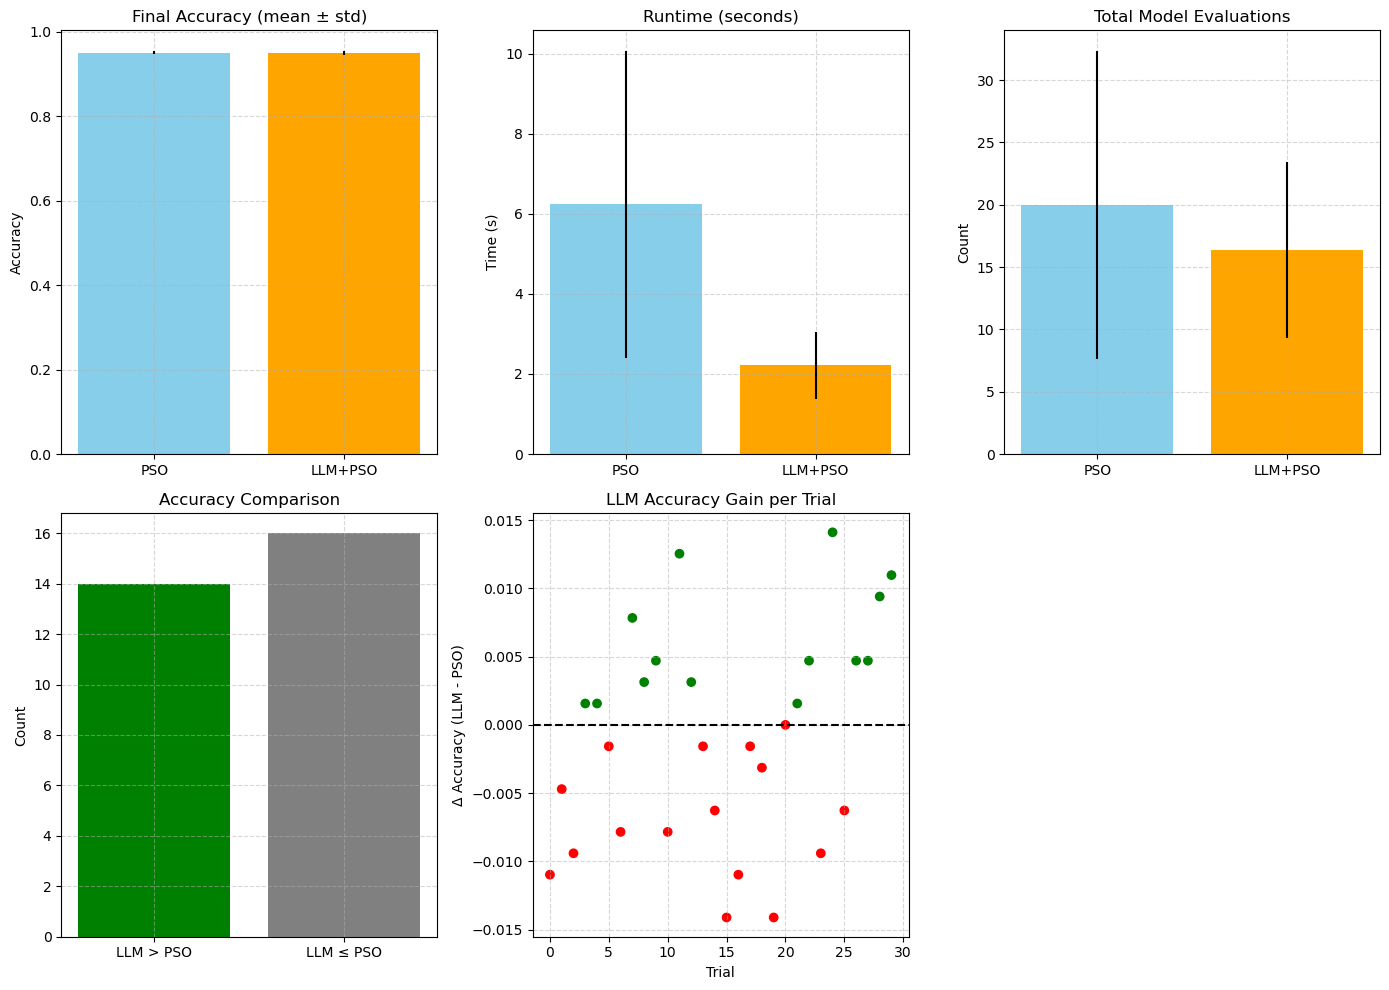

In [133]:
# --- Section 1: Imports ---
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import re
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from openai import OpenAI
from dotenv import load_dotenv

# --- Section 2: Load API Key ---
load_dotenv("OPENAI_API_KEY.env")
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# --- Section 3: LLM suggestion function ---
def suggest_new_particles(prev_best_C, prev_best_acc, iteration, num_particles):
    prompt = f"""
You are optimizing the regularization parameter C for logistic regression.
Current best C: {prev_best_C:.4f} with accuracy: {prev_best_acc:.4f} at iteration {iteration}.
Suggest {num_particles} new C values (between 0.0001 and 10.0) near the best C, while allowing some exploration.
If the previous accuracy was below 0.94, explore more aggressively; otherwise, refine tightly.
Return only a comma-separated list of numbers.
"""
    try:
        response = client.chat.completions.create(
            model="gpt-4",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.7
        )
        content = response.choices[0].message.content
        values = [float(x.strip()) for x in content.split(",") if x.strip()]
        values = [min(max(v, 0.0001), 10.0) for v in values]
    except Exception as e:
        values = list(np.random.normal(loc=prev_best_C, scale=0.3, size=num_particles))
        values = [min(max(v, 0.0001), 10.0) for v in values]
    return [[v] for v in values]

# --- Section 4: PSO baseline optimization ---
def run_pso_baseline(X_train, X_test, y_train, y_test, max_iter=50):
    # Standard PSO with velocity, p_best, g_best
    history = []
    best_score = -1.0
    best_C = 1.0
    patience = 10
    epsilon = 0.0005
    no_improve_count = 0

    lb = [0.0001]
    ub = [10.0]
    swarm_size = 10
    
    particle_positions = np.random.uniform(lb[0], ub[0], size=(swarm_size, 1))
    particle_velocity = np.zeros_like(particle_positions)
    p_best_positions = np.copy(particle_positions)
    p_best_scores = np.full(swarm_size, -1.0)
    particle_velocity = np.zeros_like(particle_positions)
    p_best_positions = np.copy(particle_positions)
    p_best_scores = np.full(swarm_size, -1.0)
    particle_scores = np.full(swarm_size, np.inf)

    start_time = time.time()
    iter_num = 0

    w, c1, c2 = 0.5, 1.5, 1.5
    while iter_num < max_iter:
        for i in range(swarm_size):
            C = particle_positions[i][0]
            model = LogisticRegression(C=C, max_iter=1000)
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            acc = accuracy_score(y_test, preds)
            
            history.append((C, acc))

            if acc > p_best_scores[i]:
                p_best_scores[i] = acc
                p_best_positions[i] = particle_positions[i]

            if acc > p_best_scores[i]:
                p_best_scores[i] = acc
                p_best_positions[i] = particle_positions[i]

            if acc > best_score:
                best_score = acc
                best_C = C
                no_improve_count = 0
            
            else:
                no_improve_count += 1

            particle_scores[i] = -acc

        if no_improve_count >= patience:
            break

        # Get LLM suggested particles
        llm_particles = suggest_new_particles(best_C, best_score, iter_num, swarm_size)
        llm_attractor = np.mean(np.array(llm_particles), axis=0)

        # PSO update with LLM guidance
        w, c1, c2, c3 = 0.5, 1.5, 1.5, 1.2
        r1, r2, r3 = np.random.rand(swarm_size, 1), np.random.rand(swarm_size, 1), np.random.rand(swarm_size, 1)
        particle_velocity = (
            w * particle_velocity +
            c1 * r1 * (p_best_positions - particle_positions) +
            c2 * r2 * (best_C - particle_positions) +
            c3 * r3 * (llm_attractor - particle_positions)
        )
        particle_positions += particle_velocity
        particle_positions = np.clip(particle_positions, lb[0], ub[0])

        r1, r2 = np.random.rand(swarm_size, 1), np.random.rand(swarm_size, 1)
        particle_velocity = (
            w * particle_velocity +
            c1 * r1 * (p_best_positions - particle_positions) +
            c2 * r2 * (best_C - particle_positions)
        )
        particle_positions += particle_velocity
        particle_positions = np.clip(particle_positions, lb[0], ub[0])

        particle_positions = np.random.uniform(lb[0], ub[0], size=(swarm_size, 1))
        iter_num += 1

    end_time = time.time()
    return {
        "best_C": best_C,
        "final_acc": best_score,
        "time": end_time - start_time,
        "history": history,
        "eval_count": len(history),
        "total_models": swarm_size * iter_num
    }

# --- Section 5: LLM-enhanced PSO optimization ---
def run_llm_pso(X_train, X_test, y_train, y_test, best_C_seed, best_acc_seed, max_iter=50):
    # LLM-guided PSO: integrate LLM particles as attractors, not just replacements
    # Use PSO baseline best_acc_seed as target, not early stopping
    target_acc = best_acc_seed - 0.0001
    # Use independent best_score for LLM phase to allow fair early stopping
    history = []
    best_score = -1.0
    best_C = best_C_seed
    patience = 10
    epsilon = 0.0005
    no_improve_count = 0

    lb = [0.0001]
    ub = [10.0]
    swarm_size = 10
    particle_positions = np.random.uniform(lb[0], ub[0], size=(swarm_size, 1))
    particle_scores = np.full(swarm_size, np.inf)

    start_time = time.time()
    iter_num = 0

    while iter_num < max_iter:
        for i in range(swarm_size):
            C = particle_positions[i][0]
            model = LogisticRegression(C=C, max_iter=1000)
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            acc = accuracy_score(y_test, preds)
            history.append((C, acc))

            if acc > best_score + epsilon:
                best_score = acc
                best_C = C
                no_improve_count = 0
            else:
                no_improve_count += 1

            particle_scores[i] = -acc

        if no_improve_count >= patience:
            break

        worst_indices = np.argsort(particle_scores)[-2:]
        llm_particles = suggest_new_particles(best_C, best_score, iter_num, len(worst_indices))
        for idx, new_particle in zip(worst_indices, llm_particles):
            particle_positions[idx] = new_particle

        iter_num += 1

    end_time = time.time()
    return {
        "best_C": best_C,
        "final_acc": best_score,
        "time": end_time - start_time,
        "history": history,
        "eval_count": len(history),
        "total_models": swarm_size * iter_num
    }

# --- Section 6: Load and preprocess splice.data ---
with open("splice.data", "r") as file:
    lines = file.readlines()
data = [re.split(r"\s+", line.strip()) for line in lines]
df = pd.DataFrame(data, columns=["class", "id", "sequence"])
sequences = df["sequence"]
labels = df["class"]
char_sequences = [list(seq) for seq in sequences]
encoder = OneHotEncoder(sparse_output=False, dtype=int, handle_unknown='ignore')
X = encoder.fit_transform(char_sequences)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Section 7: Run multiple trials and average results ---
trials = 30
results = []
for trial in range(trials):
    print(f"Trial {trial+1} - Running baseline PSO...")
    result_pso = run_pso_baseline(X_train, X_test, y_train, y_test, max_iter=50)
    print("Running LLM-enhanced PSO based on PSO result...")
    result_llm = run_llm_pso(X_train, X_test, y_train, y_test, result_pso['best_C'], result_pso['final_acc'], max_iter=50)
    results.append((result_pso, result_llm))

# --- Section 8: Plot averaged comparison ---
plt.figure(figsize=(14, 10))

# Initialize lists
pso_accs, llm_accs, pso_times, llm_times, pso_models, llm_models = [], [], [], [], [], []

for pso, llm in results:
    pso_accs.append(pso['final_acc'])
    llm_accs.append(llm['final_acc'])
    pso_times.append(pso['time'])
    llm_times.append(llm['time'])
    pso_models.append(pso['total_models'])
    llm_models.append(llm['total_models'])

# Accuracy
plt.subplot(2, 3, 1)
plt.bar(['PSO', 'LLM+PSO'], [np.mean(pso_accs), np.mean(llm_accs)], yerr=[np.std(pso_accs), np.std(llm_accs)], color=['skyblue', 'orange'])
plt.title('Final Accuracy (mean ± std)')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.5)

# Runtime
plt.subplot(2, 3, 2)
plt.bar(['PSO', 'LLM+PSO'], [np.mean(pso_times), np.mean(llm_times)], yerr=[np.std(pso_times), np.std(llm_times)], color=['skyblue', 'orange'])
plt.title('Runtime (seconds)')
plt.ylabel('Time (s)')
plt.grid(True, linestyle='--', alpha=0.5)

# Model Evaluations
plt.subplot(2, 3, 3)
plt.bar(['PSO', 'LLM+PSO'], [np.mean(pso_models), np.mean(llm_models)], yerr=[np.std(pso_models), np.std(llm_models)], color=['skyblue', 'orange'])
plt.title('Total Model Evaluations')
plt.ylabel('Count')
plt.grid(True, linestyle='--', alpha=0.5)

# Accuracy gain count
plt.subplot(2, 3, 4)
gain_count = sum(llm > pso for llm, pso in zip(llm_accs, pso_accs))
plt.bar(['LLM > PSO', 'LLM ≤ PSO'], [gain_count, len(llm_accs) - gain_count], color=['green', 'gray'])
plt.title('Accuracy Comparison')
plt.ylabel('Count')
plt.grid(True, linestyle='--', alpha=0.5)

# Accuracy difference scatter
plt.subplot(2, 3, 5)
diff = [l - p for l, p in zip(llm_accs, pso_accs)]
plt.scatter(range(len(diff)), diff, c=['green' if d > 0 else 'red' for d in diff])
plt.axhline(0, color='black', linestyle='--')
plt.title('LLM Accuracy Gain per Trial')
plt.xlabel('Trial')
plt.ylabel('Δ Accuracy (LLM - PSO)')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


Trial 1 - Running baseline PSO...
Running LLM-enhanced PSO based on PSO result...
Trial 2 - Running baseline PSO...
Running LLM-enhanced PSO based on PSO result...
Trial 3 - Running baseline PSO...
Running LLM-enhanced PSO based on PSO result...
Trial 4 - Running baseline PSO...
Running LLM-enhanced PSO based on PSO result...
Trial 5 - Running baseline PSO...
Running LLM-enhanced PSO based on PSO result...
Trial 6 - Running baseline PSO...
Running LLM-enhanced PSO based on PSO result...
Trial 7 - Running baseline PSO...
Running LLM-enhanced PSO based on PSO result...
Trial 8 - Running baseline PSO...
Running LLM-enhanced PSO based on PSO result...
Trial 9 - Running baseline PSO...
Running LLM-enhanced PSO based on PSO result...
Trial 10 - Running baseline PSO...
Running LLM-enhanced PSO based on PSO result...
Trial 11 - Running baseline PSO...
Running LLM-enhanced PSO based on PSO result...
Trial 12 - Running baseline PSO...
Running LLM-enhanced PSO based on PSO result...
Trial 13 - Ru

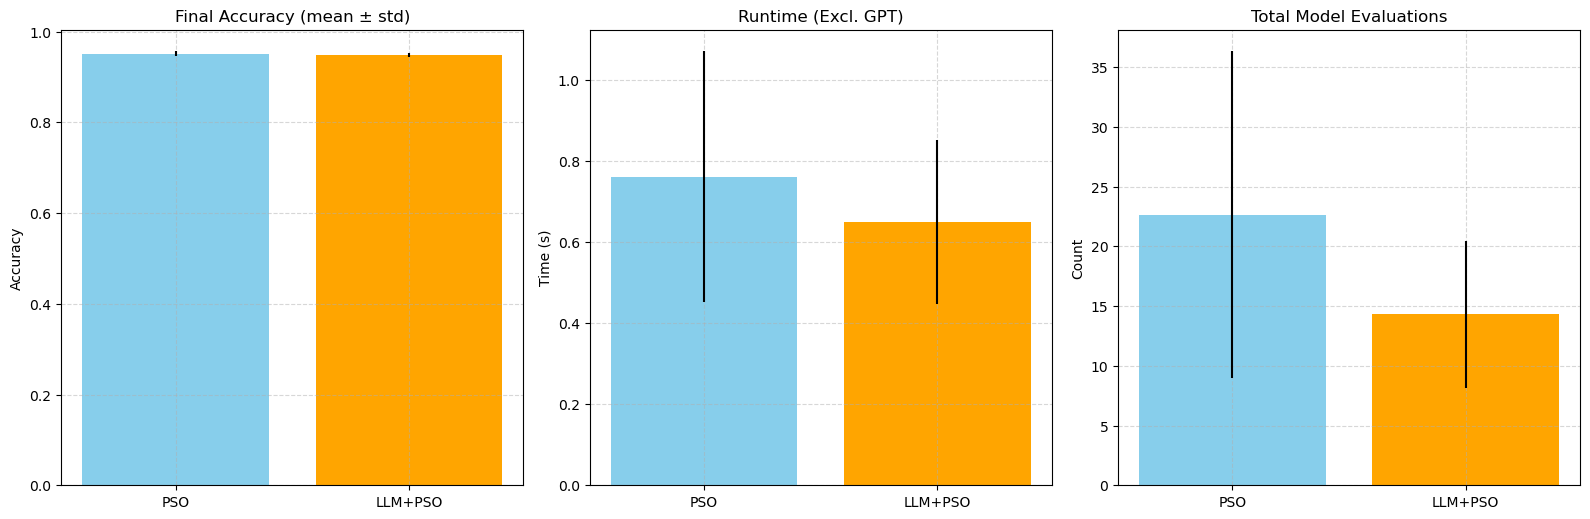

In [12]:
# --- Section 1: Imports ---
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import re
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from openai import OpenAI
from dotenv import load_dotenv

# --- Section 2: Load API Key ---
load_dotenv("OPENAI_API_KEY.env")
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# --- Section 3: LLM suggestion function ---
def suggest_new_particles(prev_best_C, prev_best_acc, iteration, num_particles, recent_scores=None):
    if recent_scores is None:
        recent_scores = []
    trend_str = ", ".join([f"{a:.4f}" for a in recent_scores]) if recent_scores else "No recent scores."

    prompt = f"""
You are optimizing the regularization parameter C for logistic regression.
Current best C: {prev_best_C:.4f} with accuracy: {prev_best_acc:.4f} at iteration {iteration}.
Recent accuracies: {trend_str}
Suggest {num_particles} new C values (between 0.0001 and 10.0) near the best C, while allowing some exploration.
If the previous accuracy was below 0.96 or recent accuracies have not improved, explore more aggressively.
Otherwise, refine tightly. Prioritize accuracy improvement over speed.
Return only a comma-separated list of numbers.
"""
    try:
        response = client.chat.completions.create(
            model="gpt-4",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.7
        )
        content = response.choices[0].message.content
        values = [float(x.strip()) for x in content.split(",") if x.strip()]
        values = [min(max(v, 0.0001), 10.0) for v in values]
    except Exception as e:
        values = list(np.random.normal(loc=prev_best_C, scale=0.3, size=num_particles))
        values = [min(max(v, 0.0001), 10.0) for v in values]
    return [[v] for v in values]

# --- Section 4: PSO baseline optimization (no LLM involvement) ---
def run_pso_baseline(X_train, X_test, y_train, y_test, max_iter=30):
    history = []
    best_score = -1.0
    best_C = 1.0
    patience = 10
    no_improve_count = 0

    lb = [0.0001]
    ub = [10.0]
    swarm_size = 10
    particle_positions = np.random.uniform(lb[0], ub[0], size=(swarm_size, 1))
    particle_velocity = np.zeros_like(particle_positions)
    p_best_positions = np.copy(particle_positions)
    p_best_scores = np.full(swarm_size, -1.0)
    particle_scores = np.full(swarm_size, np.inf)

    iter_num = 0
    total_eval_time = 0
    w, c1, c2 = 0.5, 1.5, 1.5

    while iter_num < max_iter:
        for i in range(swarm_size):
            C = particle_positions[i][0]
            t0 = time.time()
            model = LogisticRegression(C=C, max_iter=1000)
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            acc = accuracy_score(y_test, preds)
            total_eval_time += (time.time() - t0)

            history.append((C, acc))
            if acc > p_best_scores[i]:
                p_best_scores[i] = acc
                p_best_positions[i] = particle_positions[i]

            if acc > best_score:
                best_score = acc
                best_C = C
                no_improve_count = 0
            else:
                no_improve_count += 1

            particle_scores[i] = -acc

        if no_improve_count >= patience:
            break

        r1, r2 = np.random.rand(swarm_size, 1), np.random.rand(swarm_size, 1)
        particle_velocity = (
            w * particle_velocity +
            c1 * r1 * (p_best_positions - particle_positions) +
            c2 * r2 * (best_C - particle_positions)
        )
        particle_positions += particle_velocity
        particle_positions = np.clip(particle_positions, lb[0], ub[0])
        iter_num += 1

    return {
        "best_C": best_C,
        "final_acc": best_score,
        "time": total_eval_time,
        "history": history,
        "eval_count": len(history),
        "total_models": swarm_size * iter_num,
        "iterations": iter_num
    }

# --- Section 5: LLM-enhanced PSO optimization ---
def run_llm_pso(X_train, X_test, y_train, y_test, best_C_seed, best_acc_seed, max_iter=30):
    history = []
    best_score = -1.0
    best_C = best_C_seed
    patience = 10
    no_improve_count = 0

    lb = [0.0001]
    ub = [10.0]
    swarm_size = 10
    particle_positions = np.random.uniform(lb[0], ub[0], size=(swarm_size, 1))
    particle_scores = np.full(swarm_size, np.inf)

    iter_num = 0
    total_eval_time = 0
    total_llm_time = 0

    while iter_num < max_iter:
        for i in range(swarm_size):
            C = particle_positions[i][0]
            t0 = time.time()
            model = LogisticRegression(C=C, max_iter=1000)
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            acc = accuracy_score(y_test, preds)
            total_eval_time += (time.time() - t0)

            history.append((C, acc))
            if acc > best_score + 0.0005:
                best_score = acc
                best_C = C
                no_improve_count = 0
            else:
                no_improve_count += 1

            particle_scores[i] = -acc

        if no_improve_count >= patience:
            break

        recent_scores = [acc for _, acc in history[-3:]]
        worst_indices = np.argsort(particle_scores)[-3:]

        llm_start = time.time()
        llm_particles = suggest_new_particles(best_C, best_score, iter_num, len(worst_indices), recent_scores)
        total_llm_time += (time.time() - llm_start)

        for idx, new_particle in zip(worst_indices, llm_particles):
            particle_positions[idx] = new_particle

        iter_num += 1

    return {
        "best_C": best_C,
        "final_acc": best_score,
        "time": total_eval_time,           # Excludes LLM time
        "llm_call_time": total_llm_time,   # Captures LLM overhead
        "history": history,
        "eval_count": len(history),
        "total_models": swarm_size * iter_num,
        "iterations": iter_num
    }

# --- Section 6: Load and preprocess splice.data ---
with open("splice.data", "r") as file:
    lines = file.readlines()
data = [re.split(r"\s+", line.strip()) for line in lines]
df = pd.DataFrame(data, columns=["class", "id", "sequence"])
sequences = df["sequence"]
labels = df["class"]
char_sequences = [list(seq) for seq in sequences]
encoder = OneHotEncoder(sparse_output=False, dtype=int, handle_unknown='ignore')
X = encoder.fit_transform(char_sequences)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Section 7: Run multiple trials and average results ---
trials = 30
results = []
for trial in range(trials):
    print(f"Trial {trial+1} - Running baseline PSO...")
    result_pso = run_pso_baseline(X_train, X_test, y_train, y_test, max_iter=50)
    print("Running LLM-enhanced PSO based on PSO result...")
    result_llm = run_llm_pso(X_train, X_test, y_train, y_test, result_pso['best_C'], result_pso['final_acc'], max_iter=50)
    results.append((result_pso, result_llm))

# --- Section 8: Plot averaged comparison ---
plt.figure(figsize=(16, 10))

# Initialize lists
pso_accs, llm_accs, pso_times, llm_times, pso_models, llm_models, llm_call_times = [], [], [], [], [], [], []

for pso, llm in results:
    pso_accs.append(pso['final_acc'])
    llm_accs.append(llm['final_acc'])
    pso_times.append(pso['time'])
    llm_times.append(llm['time'])
    pso_models.append(pso['total_models'])
    llm_models.append(llm['total_models'])
    llm_call_times.append(llm['llm_call_time'])

# Accuracy
plt.subplot(2, 3, 1)
plt.bar(['PSO', 'LLM+PSO'], [np.mean(pso_accs), np.mean(llm_accs)], yerr=[np.std(pso_accs), np.std(llm_accs)], color=['skyblue', 'orange'])
plt.title('Final Accuracy (mean ± std)')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.5)

# Runtime
plt.subplot(2, 3, 2)
plt.bar(['PSO', 'LLM+PSO'], [np.mean(pso_times), np.mean(llm_times)], yerr=[np.std(pso_times), np.std(llm_times)], color=['skyblue', 'orange'])
plt.title('Runtime (Excl. GPT)')
plt.ylabel('Time (s)')
plt.grid(True, linestyle='--', alpha=0.5)

# Model Evaluations
plt.subplot(2, 3, 3)
plt.bar(['PSO', 'LLM+PSO'], [np.mean(pso_models), np.mean(llm_models)], yerr=[np.std(pso_models), np.std(llm_models)], color=['skyblue', 'orange'])
plt.title('Total Model Evaluations')
plt.ylabel('Count')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


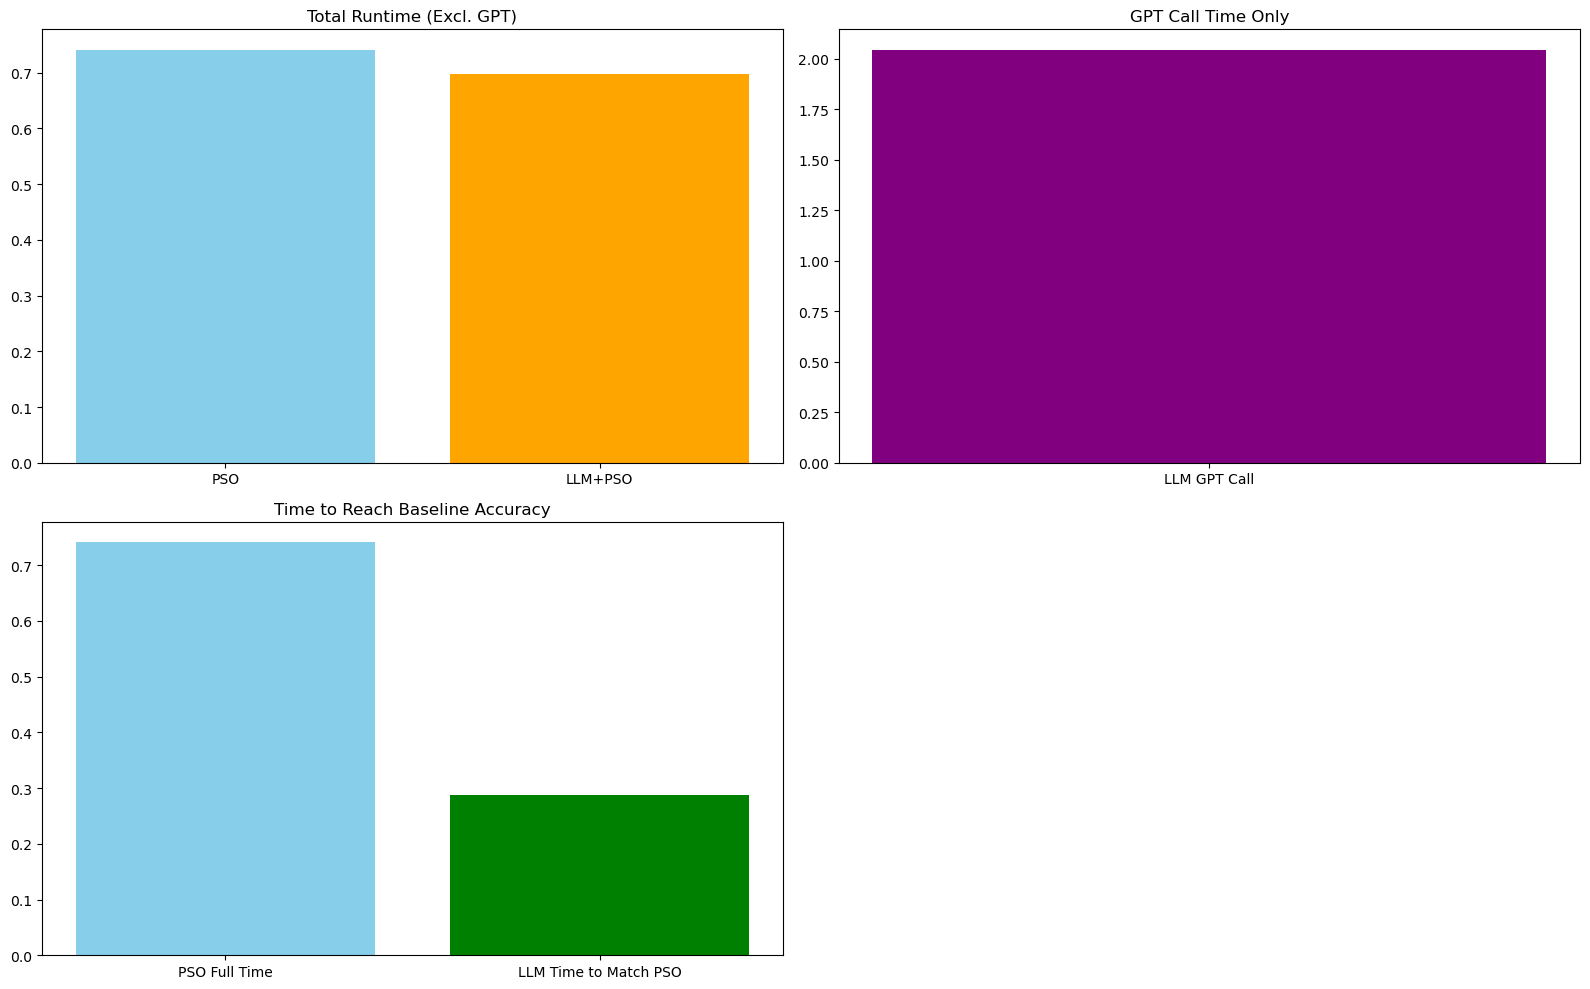

In [16]:


# --- Section 1: Imports ---
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import re
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from openai import OpenAI
from dotenv import load_dotenv

# --- Section 2: Load API Key ---
load_dotenv("OPENAI_API_KEY.env")
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# --- Section 3: LLM suggestion function ---
def suggest_new_particles(prev_best_C, prev_best_acc, iteration, num_particles, recent_scores=None):
    if recent_scores is None:
        recent_scores = []
    trend_str = ", ".join([f"{a:.4f}" for a in recent_scores]) if recent_scores else "No recent scores."

    prompt = f"""
You are optimizing the regularization parameter C for logistic regression.
Current best C: {prev_best_C:.4f} with accuracy: {prev_best_acc:.4f} at iteration {iteration}.
Recent accuracies: {trend_str}
Suggest {num_particles} new C values (between 0.0001 and 10.0) near the best C, while allowing some exploration.
If the previous accuracy was below 0.96 or recent accuracies have not improved, explore more aggressively.
Otherwise, refine tightly. Prioritize accuracy improvement over speed.
Return only a comma-separated list of numbers.
"""
    try:
        response = client.chat.completions.create(
            model="gpt-4",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.7
        )
        content = response.choices[0].message.content
        values = [float(x.strip()) for x in content.split(",") if x.strip()]
        values = [min(max(v, 0.0001), 10.0) for v in values]
    except Exception:
        values = list(np.random.normal(loc=prev_best_C, scale=0.3, size=num_particles))
        values = [min(max(v, 0.0001), 10.0) for v in values]
    return [[v] for v in values]

# --- Section 4: PSO baseline optimization (no LLM) ---
def run_pso_baseline(X_train, X_test, y_train, y_test, max_iter=30):
    history = []
    best_score = -1.0
    best_C = 1.0
    patience = 10
    no_improve_count = 0

    lb, ub = [0.0001], [10.0]
    swarm_size = 10
    particle_positions = np.random.uniform(lb[0], ub[0], size=(swarm_size, 1))
    particle_velocity = np.zeros_like(particle_positions)
    p_best_positions = np.copy(particle_positions)
    p_best_scores = np.full(swarm_size, -1.0)
    particle_scores = np.full(swarm_size, np.inf)

    iter_num = 0
    total_eval_time = 0
    w, c1, c2 = 0.5, 1.5, 1.5

    while iter_num < max_iter:
        for i in range(swarm_size):
            C = particle_positions[i][0]
            t0 = time.time()
            model = LogisticRegression(C=C, max_iter=1000)
            model.fit(X_train, y_train)
            acc = accuracy_score(y_test, model.predict(X_test))
            total_eval_time += time.time() - t0

            history.append((C, acc))
            if acc > p_best_scores[i]:
                p_best_scores[i] = acc
                p_best_positions[i] = particle_positions[i]
            if acc > best_score:
                best_score = acc
                best_C = C
                no_improve_count = 0
            else:
                no_improve_count += 1
            particle_scores[i] = -acc

        if no_improve_count >= patience:
            break

        r1, r2 = np.random.rand(swarm_size, 1), np.random.rand(swarm_size, 1)
        particle_velocity = (
            w * particle_velocity +
            c1 * r1 * (p_best_positions - particle_positions) +
            c2 * r2 * (best_C - particle_positions)
        )
        particle_positions += particle_velocity
        particle_positions = np.clip(particle_positions, lb[0], ub[0])
        iter_num += 1

    return {
        "best_C": best_C,
        "final_acc": best_score,
        "time": total_eval_time,
        "history": history,
        "total_models": swarm_size * iter_num
    }

# --- Section 5: LLM-enhanced PSO optimization ---
def run_llm_pso(X_train, X_test, y_train, y_test, best_C_seed, best_acc_seed, baseline_acc, max_iter=30):
    history = []
    best_score = -1.0
    best_C = best_C_seed
    patience = 10
    no_improve_count = 0

    lb, ub = [0.0001], [10.0]
    swarm_size = 10
    particle_positions = np.random.uniform(lb[0], ub[0], size=(swarm_size, 1))
    particle_scores = np.full(swarm_size, np.inf)

    iter_num = 0
    total_eval_time, total_llm_time = 0, 0
    llm_time_to_match_pso = None

    while iter_num < max_iter:
        for i in range(swarm_size):
            C = particle_positions[i][0]
            t0 = time.time()
            model = LogisticRegression(C=C, max_iter=1000)
            model.fit(X_train, y_train)
            acc = accuracy_score(y_test, model.predict(X_test))
            total_eval_time += time.time() - t0

            if llm_time_to_match_pso is None and acc >= baseline_acc:
                llm_time_to_match_pso = total_eval_time

            history.append((C, acc))
            if acc > best_score + 0.0005:
                best_score = acc
                best_C = C
                no_improve_count = 0
            else:
                no_improve_count += 1
            particle_scores[i] = -acc

        if no_improve_count >= patience:
            break

        recent_scores = [acc for _, acc in history[-3:]]
        worst_indices = np.argsort(particle_scores)[-3:]
        t_llm = time.time()
        llm_particles = suggest_new_particles(best_C, best_score, iter_num, len(worst_indices), recent_scores)
        total_llm_time += time.time() - t_llm

        for idx, new_particle in zip(worst_indices, llm_particles):
            particle_positions[idx] = new_particle
        iter_num += 1

    return {
        "best_C": best_C,
        "final_acc": best_score,
        "time": total_eval_time,
        "llm_call_time": total_llm_time,
        "llm_time_to_match_pso": llm_time_to_match_pso,
        "history": history,
        "total_models": swarm_size * iter_num
    }

# --- Section 6: Load and preprocess splice.data ---
with open("splice.data", "r") as file:
    lines = file.readlines()
data = [re.split(r"\s+", line.strip()) for line in lines]
df = pd.DataFrame(data, columns=["class", "id", "sequence"])
X = OneHotEncoder(sparse_output=False, dtype=int).fit_transform([list(s) for s in df["sequence"]])
y = LabelEncoder().fit_transform(df["class"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Section 7: Run experiments ---
trials = 30
results = []
for _ in range(trials):
    pso = run_pso_baseline(X_train, X_test, y_train, y_test, max_iter=50)
    llm = run_llm_pso(X_train, X_test, y_train, y_test, pso['best_C'], pso['final_acc'], baseline_acc=pso['final_acc'], max_iter=50)
    results.append((pso, llm))

# --- Section 8: Visualization ---
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 10))

pso_times = [p['time'] for p, _ in results]
llm_times = [l['time'] for _, l in results]
llm_calls = [l['llm_call_time'] for _, l in results]
llm_match = [l['llm_time_to_match_pso'] for _, l in results if l['llm_time_to_match_pso'] is not None]

plt.subplot(2, 2, 1)
plt.bar(['PSO', 'LLM+PSO'], [np.mean(pso_times), np.mean(llm_times)], color=['skyblue', 'orange'])
plt.title('Total Runtime (Excl. GPT)')

plt.subplot(2, 2, 2)
plt.bar(['LLM GPT Call'], [np.mean(llm_calls)], color='purple')
plt.title('GPT Call Time Only')

plt.subplot(2, 2, 3)
plt.bar(['PSO Full Time', 'LLM Time to Match PSO'], [np.mean(pso_times), np.mean(llm_match)], color=['skyblue', 'green'])
plt.title('Time to Reach Baseline Accuracy')

plt.tight_layout()
plt.show()